# On to the Fun Part! :D 

Now that you are all done with dataset prep, we can get to training classifiers! Let's take a quick look at an overview of the process: 

<img src="images/83554313_996871547395153_835350309861435604_n.jpg">

You have already completed part 1, the training samples being the datasets you have prepared! Now onto feature extraction and classification. 

A **feature** is just a measurable piece of data in your image that is unique to that object or class. But selecting the right features is critical to get the classification task working and this is known as **feature selection**. 

**Why do we need feature selection?**
1. Features have different discrimination power 
    * Some of them may poorly contribute to class separation (such as differing between sunny versus cloudy) 
2. Features are correlated 
    * We do not need redundant information. If multiple features are providing the same info, it is not necessary to include both. 
3. Smaller feature sets are practical: 
    * dimensionality reduction 
    * simpler/faster classification 
    * low memory usage

Keep these in mind as you play with features. Your aim is to **maximize accuracy** with the **least** amount of features as possible. You could potentially add them one at a time and see if a difference is made to see whether they are a useful feature. 

There are both **global** and **local** feature descriptors: 
    * **Global** - Quantifies an image globally and the entire image is taken for processing
    * **Local** - Quantifies specific regions in an image concerning interest points. 
    
For the weather tasks, it will be best to use global descriptors. However, perhaps you notice a pattern that is local region of interest that is a good differentiating feature, then that can be combined as well! You are the artist, let your inspiration drive you! 

Remember, these models can not actually *see* anything. Everything is being done on a numerical basis. Even the images are just stored as matricies. 

So let's go through an example and see how this works. Introducing the infamous apples versus oranges classifier! 

## Extracting Global Features 

When considering major differences between an apple and orange, we may take into though the following: 
    * Color - I know I have personally never encountered an orange-colored apple. I hope you all have not either. Please do not eat such apple. 
    * Texture - Apples appear much smoother compares to oranges 
    * Shape 
    
Let's import the necessary libraries and get the parameters set 

In [6]:
# Libraries to use 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np 
import mahotas 
import cv2 
import os 
import h5py 

# Parameters that can be changed 
# ------------------------------
# To ensure that all the input images are set to a fixed size 
size = tuple((500,500)) 
# Path to training data
train = "fruit-dataset/train"

# Create a directory named 'output' to hold labels and feature data 
if not os.path.isdir('output'):
    os.mkdir('output')
data_file = 'output/data.h5'
labels_file = 'output/labels.h5'

# Setting number of bins for color histogram 
bins = 8

### Creating functions for the global feature descriptors 

We are going to create functions for each of the features we find important: texture, color and shape. 

We can use `OpenCV` to get the color and shape information and then use the `mahotas` library to get the texture. There are many options out there that can be explored, you are free to use whatever you think will be useful. You can even mess around on this example so you feel comfortable. Luckily there are lots of docs out there for all these functions, so feel free to reference them. 

In [7]:
# Extracting color feature descriptors 
def color_features(image, mask=None): 
    # Need to convert image to HSV color space 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Calculate the color histogram and normalize
    histogram = cv2.calcHist([image], [0,1,2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(histogram,histogram)
    return histogram.flatten()

In [8]:
# Extracting shape features 
def shape_features(image): 
    # Image need to be in grayscale first 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    shape_features = cv2.HuMoments(cv2.moments(image)).flatten()
    return shape_features

In [9]:
# Extracting texture feature descriptors
def texture_features(image): 
    # Image needs to be in grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # calculate the texture feature vector 
    texture = mahotas.features.haralick(gray_img).mean(axis=0)
    return texture

Now we can extract the training labels. Remember these are the titles of the folder. So we just need to extract those. 

In [10]:
training_labels = os.listdir(train)
training_labels.sort()
print(training_labels)

['Apple', 'Not_Apple']


We will also initialize empty lists which will hold the feature vectors and the labels 

In [11]:
global_features = []
labels = []

We will now iterate through the folder to get all the images, resize them to the size we stated above and then extract the three global features we have selected. These will be concatenated using `np.hstack()` from NumPy and then make sure the features are properly associated with their designated labels. 

In [12]:
# Access subfolders in train
for name in training_labels: 
    sub_folder = os.path.join(train_path, name)
    
    # Get the subfolder name which is the label for that set of images 
    class_label = name 
    
    # Loop over the images in the sub-folder 
    list_of_images = os.listdir(sub_folder)
    for image in list_of_images: 
        
        # Read in the image 
        img = cv2.imread(os.path.join(sub_folder, image))
        
        # Resize the image 
        image = cv2.resize(img, size)
        
        # Extract features from each image 
        color = color_features(image)
        shape = shape_features(image)
        texture = texture_features(image)
        
        # Concatenate features 
        global_feature = np.hstack([color, shape, texture])
        
        # Update feature vectors and list of labels 
        labels.append(name)
        global_features.append(global_feature)
        
    print("Finished processing sub-folder: {}". format(name))

print("Global feature extraction is complete :D")

Finished processing sub-folder: Apple
Finished processing sub-folder: Not_Apple
Global feature extraction is complete :D


Since we are using different global features, we want to make sure one feature by numerical value alone does not dominate another. So we will normalize them, in this case from 0 to 1, assign a unique number to the lables using `LableEncoder()` and then save the features and labels locally in a `.h5` file. 

The HDF5 file format may be new to you. Feel free to get learnt at this link: https://www.neonscience.org/about-hdf5

You can use other file types if you are more comfortable (like csv). HDF5 is just friendlier if you have a lot of data. 

In [13]:
# Encode the labels to unique name 
target_names = np.unique(labels)
target = LabelEncoder().fit_transform(labels)

# Scale the features 
scaler = MinMaxScaler(feature_range=(0,1))
rescaled = scaler.fit_transform(global_features)

# Save features and labels in HDf5 format 
data_features = h5py.File(data_file, 'w')
data_features.create_dataset('dataset', data=np.array(rescaled))

label = h5py.File(labels_file, 'w')
label.create_dataset('dataset', data=np.array(target))

data_features.close()
label.close()

## Now Let's Train our Models! 

Now that we have our features, we can start training. `scikit-learn` Has a lot of models we can play with. Feel free to explore and there a lot of references available if you would like to gain more knowledge about the models! https://scikit-learn.org/stable/

We will be training the following models from `scikit-learn`: 
- Support Vector Machine 
- Decision Trees 
- K-Nearest Neighbors 
- Logistic Regression 
- Linear Discriminant Analysis 
- Gaussian Naive Bayes 
- Random Forests 

It is worth getting to know these models, especially to get more of an intuition for the tunable parameters and to pick good choices in such decisions.

To get the accuracy we need to split the training into test and train but there is a nifty tool `train_test_split` in scikit-learn that will do this for you. Our additional `test` folder is to evaluate the model in different ways if we would like. But this library will do lots of the hard work for you! 

We are using **k-fold Cross Validation** to assess a model's accuracy. A nice introduction can be found here: https://machinelearningmastery.com/k-fold-cross-validation/

Let's get training! 

In [14]:
# Import libraries 
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

In [15]:
# Parameters that can be changed 
# ------------------------------
# argument needed for Random Forests Model 
trees = 2 

# for splitting the dataset, designate a percent to assign to test
# In our case let's try 10 percent 
test_size = 0.10 

# For Logistic Regression 
# seed of pseudo random number generator to use when shuffling the data
seed      = 1

# Define data paths 
train = "fruit-dataset/train"
test  = "fruit-dataset/test"

# Access features and labels 
data_file    = 'output/data.h5'
labels_file  = 'output/labels.h5'

# Define our scoring metric 
scoring    = "accuracy"

if not os.path.exists(test):
    os.makedirs(test)

In [16]:
# Get the training labels 
train_labels = os.listdir(train)
train_labels.sort()

# Create the machine learning models 
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# Initialize empty variabes to hold results and names 
results = []
names   = []

# Import our global feature vectors and their labels 
data  = h5py.File(data_file, 'r')
label = h5py.File(labels_file, 'r')

global_features_string = data['dataset']
global_labels_string   = label['dataset']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

data.close()
label.close()

We can verify everything worked well by checking the shape of the feature vectors and labels, which should match 

In [17]:
# Verifying 
print("Feature vector shape - {}".format(global_features.shape))
print("Feature vector shape - {}".format(global_labels.shape))

Feature vector shape - (410, 532)
Feature vector shape - (410,)


Now we can split our training data into test and train.

In [18]:
# Splitting into train and test data 
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(global_features),
                                                                  np.array(global_labels),
                                                                  test_size=test_size,
                                                                  random_state=seed)
# Verify values correctly correspond 
print("Train data - {}".format(trainData.shape))
print("Train labels - {}".format(trainLabels.shape))
print("Test data - {}".format(testData.shape))
print("Test labels - {}".format(testLabels.shape))

Train data - (369, 532)
Train labels - (369,)
Test data - (41, 532)
Test labels - (41,)


Now we can perform **k-fold Cross Validation** and check the **accuracy** of the models. I chose 5 splits for this simple dataset, but this is a parameter you can play with and will become more familiar with based of the reference material. 



LR: 0.964791 (0.013738)
LDA: 0.739837 (0.044717)
KNN: 0.948389 (0.031646)
CART: 0.943095 (0.015737)
RF: 0.872640 (0.025001)
NB: 0.837394 (0.098569)
SVM: 0.953906 (0.013871)


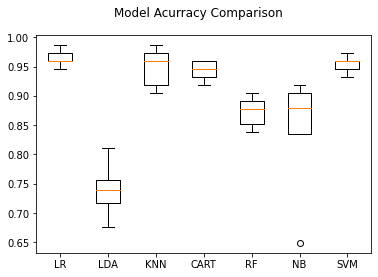

In [19]:
for name, model in models:
    kfold = KFold(n_splits=5, random_state=seed)
    cv_results = cross_val_score(model, trainData, trainLabels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Model Acurracy Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

The models all performed quite well based on the train data. The weakest appears to be the `Linear Discriminant Analysis`. 

Now that we have an idea about the accuracy of the models, we can build the stronger models and fit it with the train data and then test with on our test data after extracting their global features. For this example I have worked out an example for `Random Forests` and `Support Vector Machine`. The models are super well documented and can easily be modified for whichever model you would like. 

A good exercise may be to try to code up `Linear Discriminant Analysis` on your own and see how the results will vary since it is the weakest model. 

## Testing Random Forest Model 

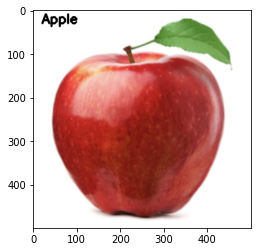

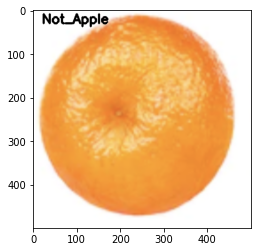

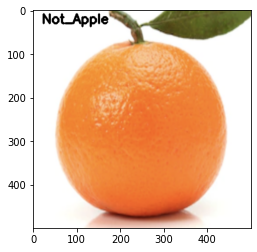

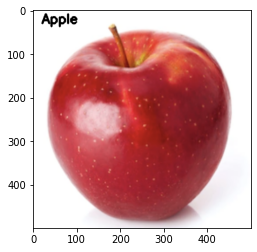

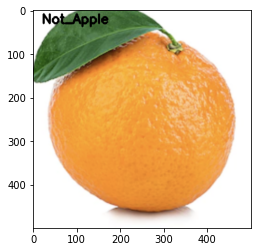

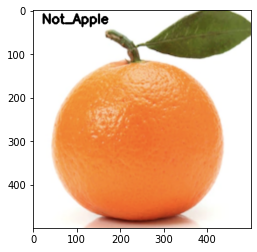

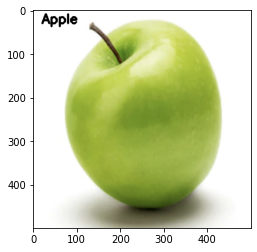

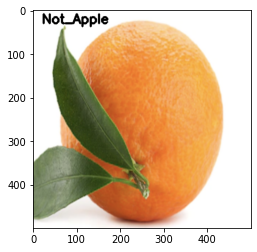

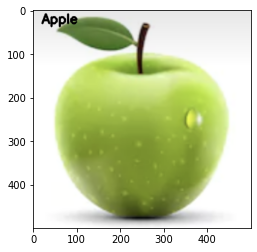

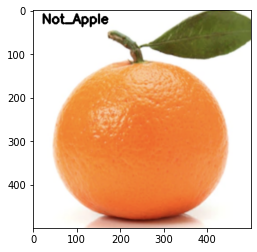

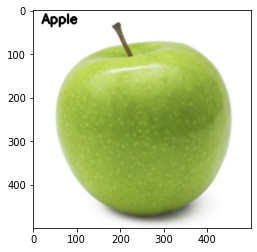

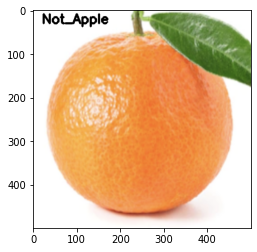

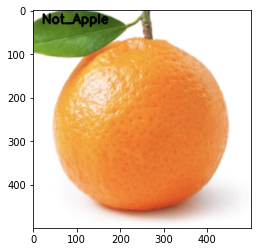

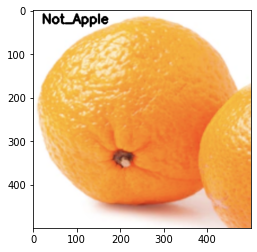

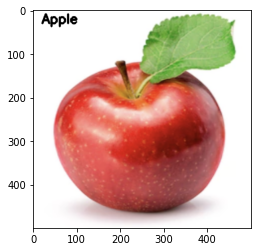

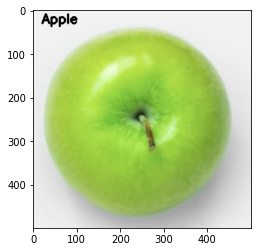

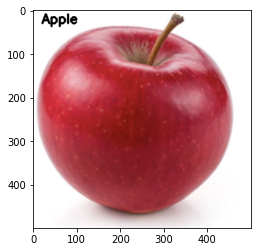

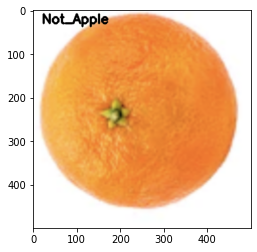

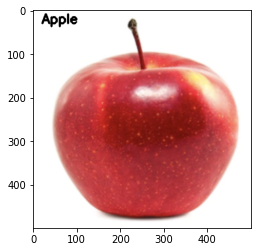

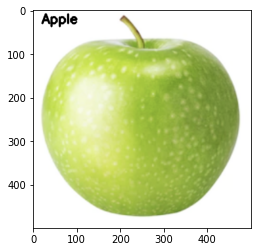

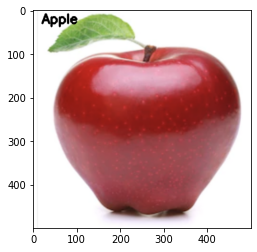

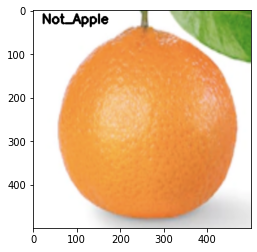

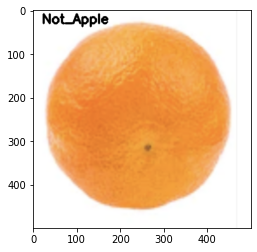

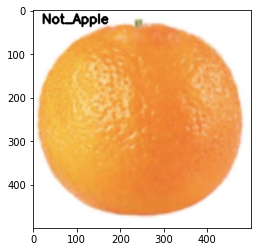

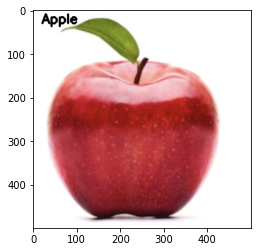

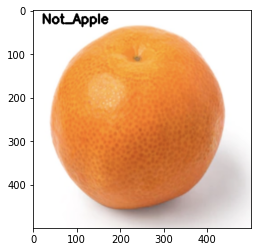

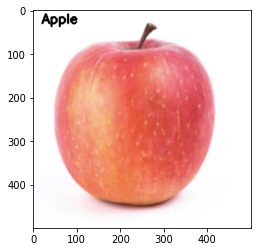

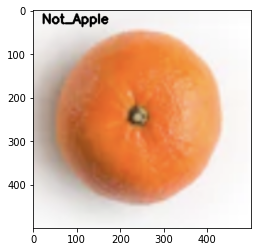

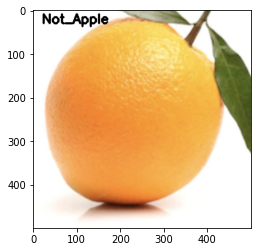

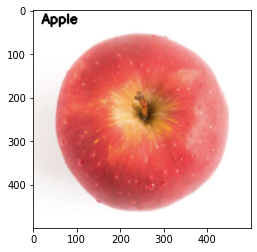

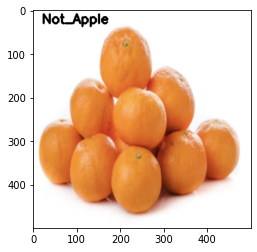

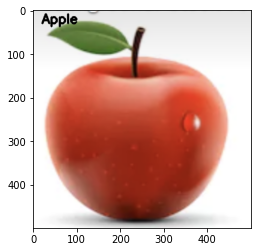

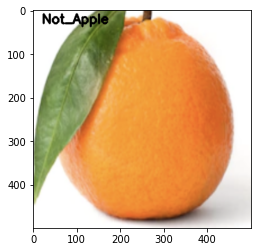

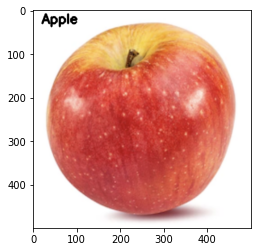

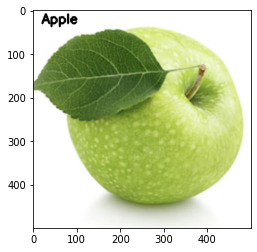

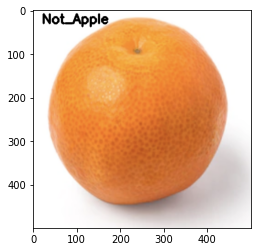

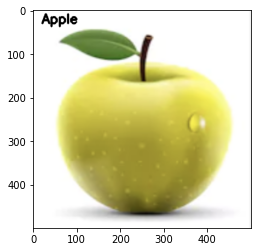

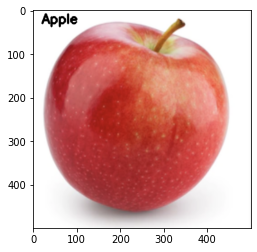

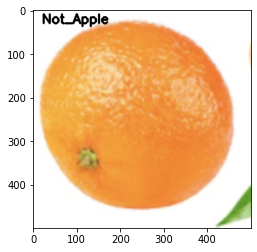

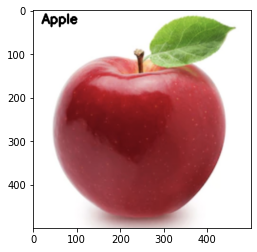

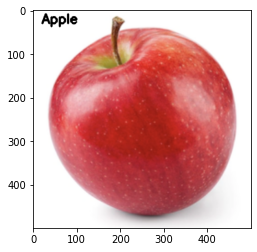

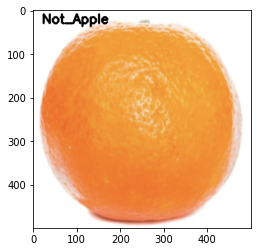

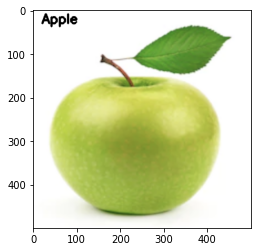

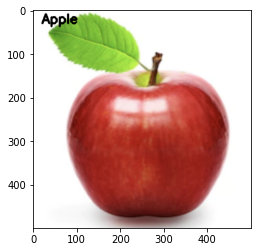

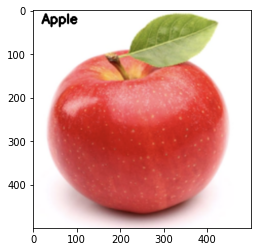

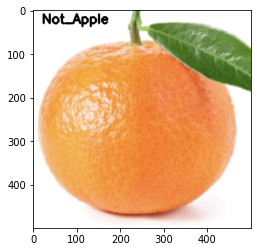

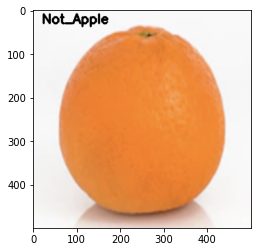

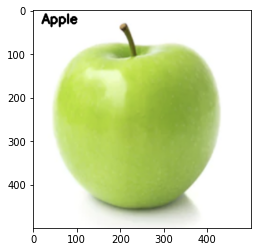

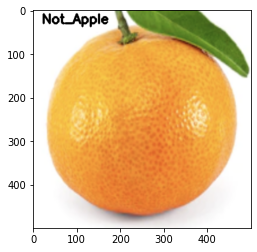

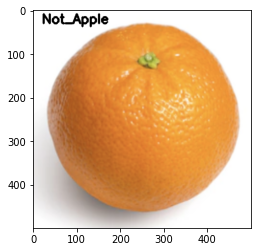

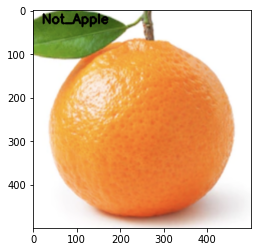

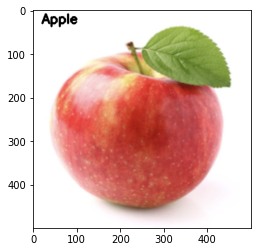

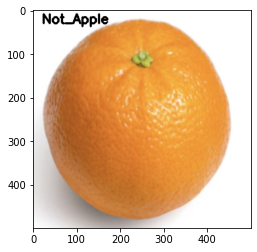

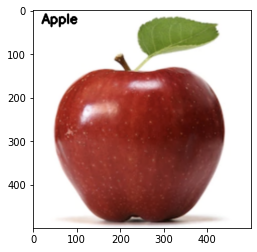

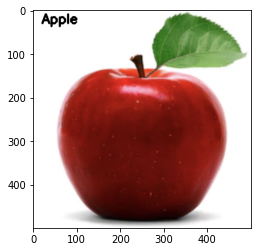

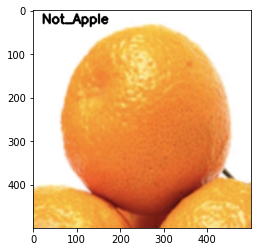

In [20]:
# Lets use matplot lib to visualize our results 
import matplotlib.pyplot as plt

# Then create the Random Forest Model 
random_forest  = RandomForestClassifier(n_estimators=trees, random_state=seed)

# Fit the training data to the model 
random_forest.fit(trainData, trainLabels)

# Go through test images 
for file in glob.glob(test + "/*.png"):
    # Read the image
    image = cv2.imread(file)

    # Resize the image
    image = cv2.resize(image, size)

    # Extract features from each image 
    color = color_features(image)
    shape = shape_features(image)
    texture = texture_features(image)

    # Concatenate features 
    global_feature = np.hstack([color, shape, texture])
    
    # Scale features 
    rescaled_feature = scaler.transform(global_feature.reshape(1, -1))
    
    # Predict on test input 
    prediction = random_forest.predict(rescaled_feature.reshape(1,-1))[0]
    
    # Place predicted label onto image to visualize
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_ITALIC, 1.0, (0,0,0), 3)

    # Display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

## Training and Testing Support Vector Machine

I am demonstrating how to set up a separate model, here it is for SVM. There are actually very little changes between the two as you can see! 

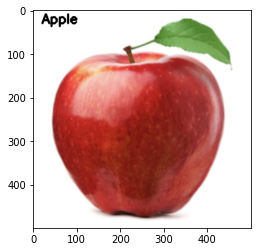

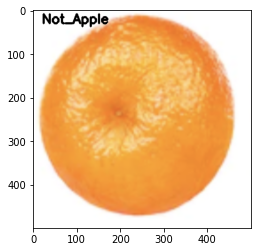

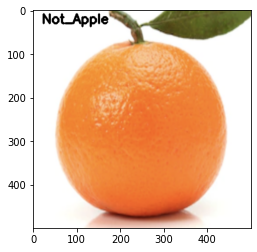

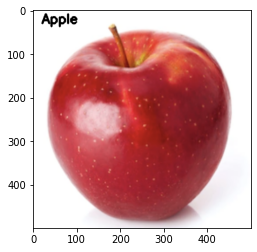

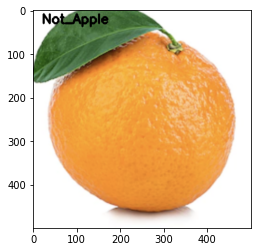

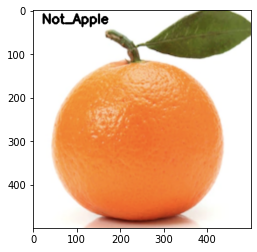

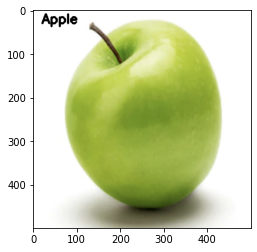

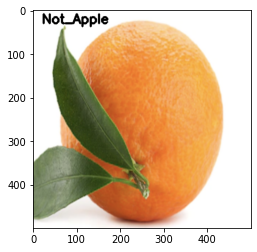

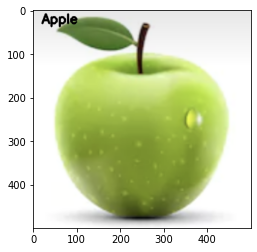

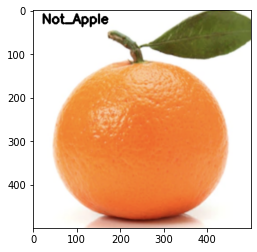

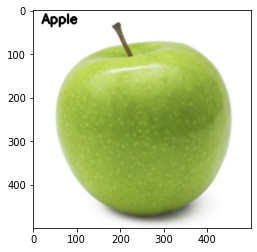

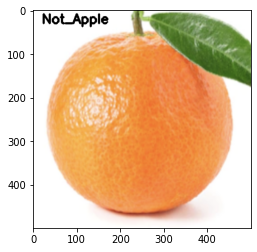

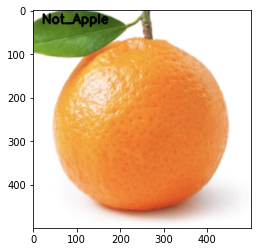

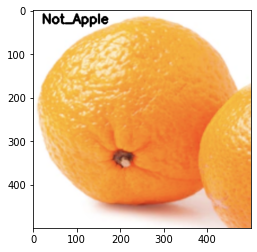

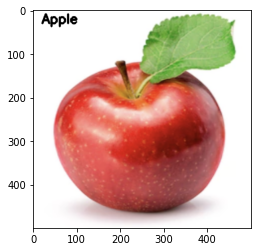

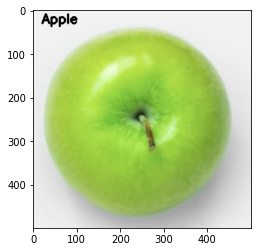

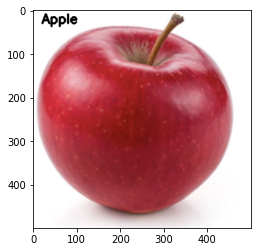

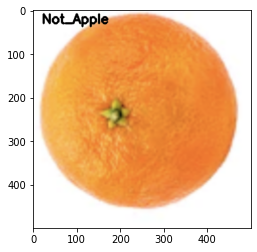

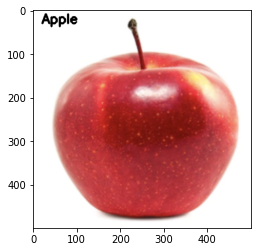

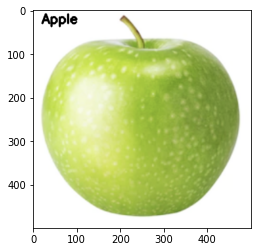

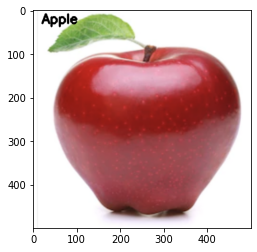

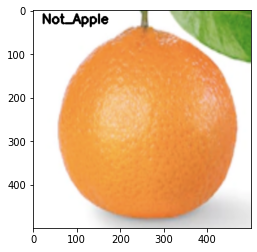

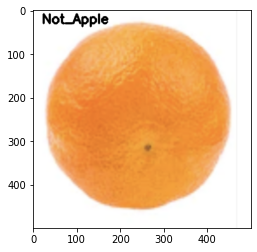

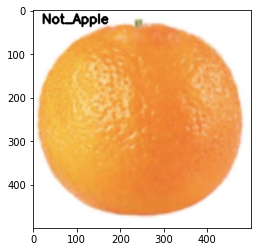

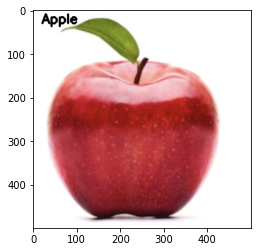

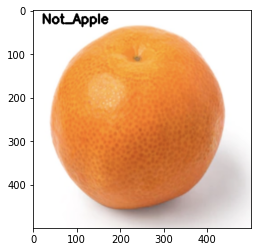

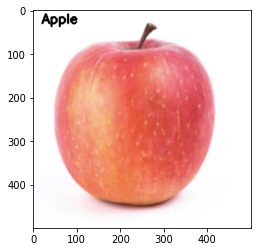

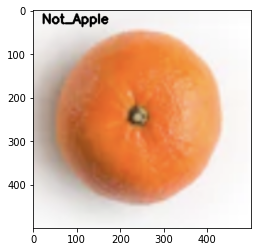

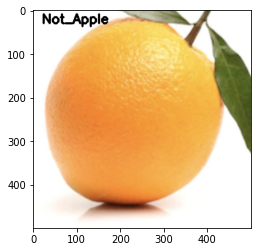

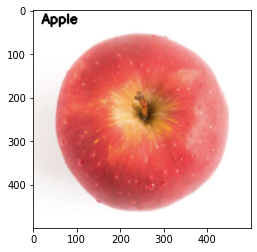

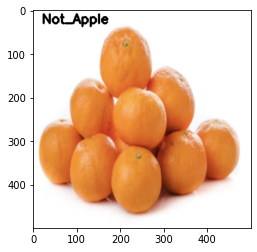

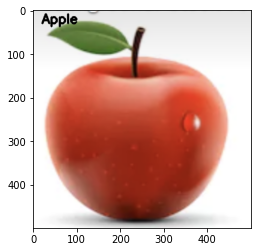

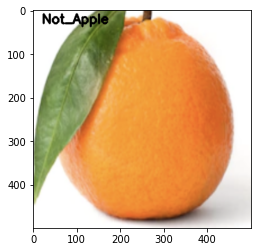

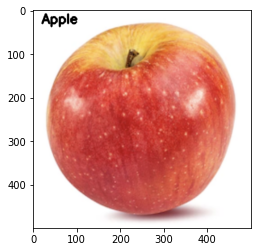

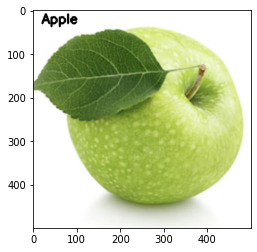

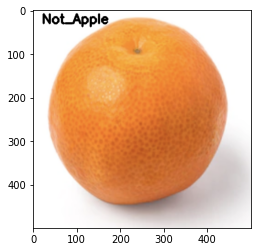

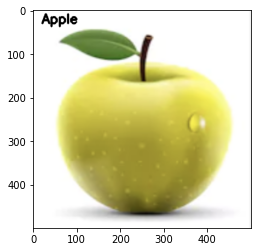

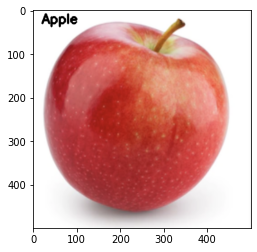

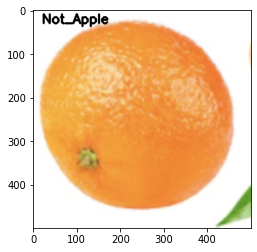

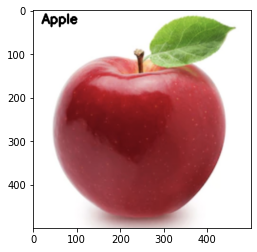

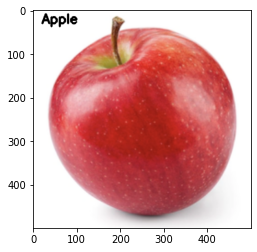

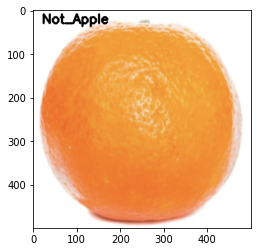

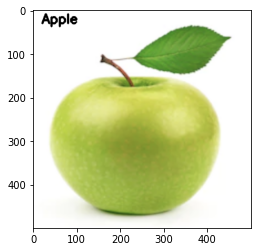

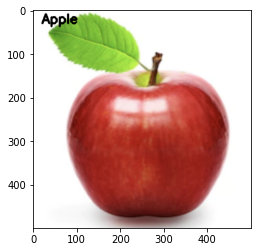

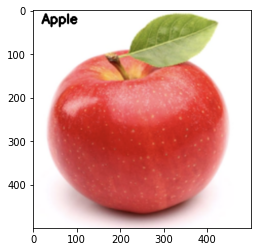

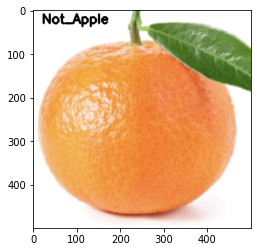

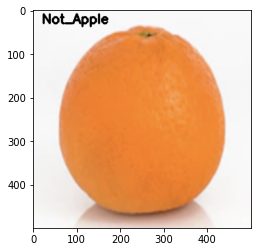

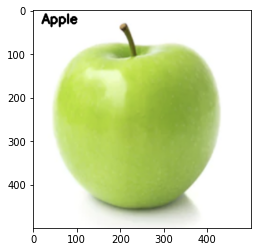

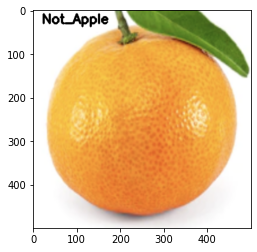

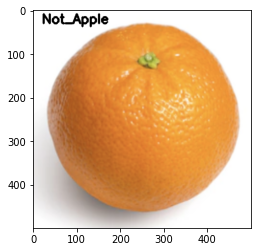

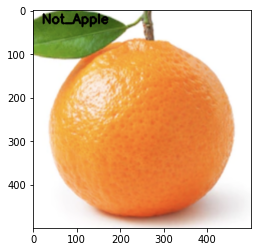

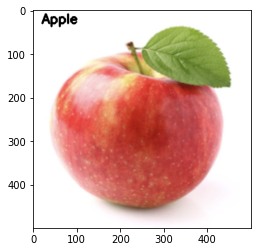

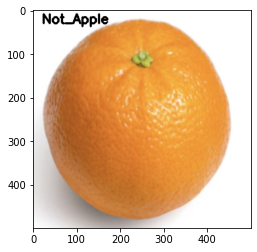

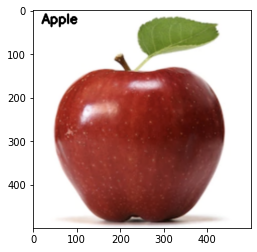

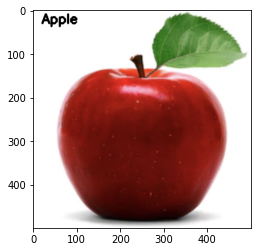

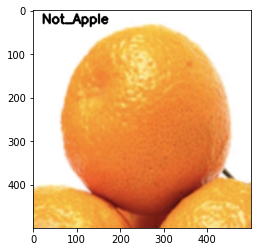

In [21]:
# For visualizing results 
import matplotlib.pyplot as plt

# Create the SVM 
svm_model = SVC(kernel='linear')

# Fit the training data to the model
svm_model.fit(trainData, trainLabels)

# Go through test images 
for file in glob.glob(test + "/*.png"):
    # Read the image
    image = cv2.imread(file)

    # Resize the image
    image = cv2.resize(image, size)

    # Extract features from each image 
    color = color_features(image)
    shape = shape_features(image)
    texture = texture_features(image)

    # Concatenate features 
    global_feature = np.hstack([color, shape, texture])
    
    # Scale features 
    rescaled_feature = scaler.transform(global_feature.reshape(1, -1))

    # Predict on test input 
    prediction = svm_model.predict(rescaled_feature)[0]
    
    # Place predicted label onto image to visualize
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_ITALIC, 1.0, (0,0,0), 3)

    # Display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Not so bad right? 

Here are some things you should try to do: 

1. Really get to know this code! Look up any confusing functions, see what the inputs and outputs are and make sure it makes sense! Change things and see what differences have. Break the code and fix it! Do whatever you need to make sure you understand it :) 
2. Train your one of the other models that is not a SVM or Random Forest 
3. Try creating a model for the data you have (like a Sunny versus Not_Sunny classifier). Remember, it will require some thought regarding the features for weather (which will be different from this example). Aim for high accuracy with the least number of features! 
4. Jupyter notebook is only for visualizing and getting familiar with the code. You will need to migrate the code out of the notebook and make sure the trained model is **persistent**. More info on that can be found here: https://scikit-learn.org/stable/modules/model_persistence.html

As always I am always here to help! :) Have fun with this! You're a feature magician now. Google is also a great resource, there are countless examples of fruit classifiers and simple binary models! :) 

Happy coding and diving into traditional computer vision :) 